In [0]:
import os ; os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/Recurrent Neural Network')

In [2]:
%tensorflow_version 1.x
import tensorflow.compat.v1 as tf


import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from utils import init_weight, all_parity_pairs_with_sequence_labels

TensorFlow 1.x selected.


In [0]:
class SimpleRNN:
    def __init__(self, M):
        self.M = M #hidden layer size

    def fit(self, X, Y, learning_rate=1.0, mu=0.99, reg=1.0, activation=tf.tanh, epochs=100, show_fig=False):
        N, T, D = X.shape
        K = len(set(Y.flatten()))
        M = self.M
        self.f = activation

        #initial weights
        Wx = init_weight(D,M).astype(np.float32)
        Wh = init_weight(M,M).astype(np.float32)
        bh = np.zeros(M, dtype=np.float32)
        h0 = np.zeros(M, dtype=np.float32)
        Wo = init_weight(M, K).astype(np.float32)
        bo = np.zeros(K, dtype=np.float32)

        #make them tensorflow shared variable
        self.Wx = tf.Variable(Wx)
        self.Wh = tf.Variable(Wh)
        self.bh = tf.Variable(bh)
        self.h0 = tf.Variable(h0)
        self.Wo = tf.Variable(Wo)
        self.bo = tf.Variable(bo)

        tfX = tf.placeholder(tf.float32, shape=(T,D), name='X')
        tfY = tf.placeholder(tf.int32, shape=(T,), name='Y')

        XWx = tf.matmul(tfX, self.Wx)

        def recurrence(h_t1, xw_t):
            #matmul works with 2-D objects
            #we want to return a 1-D object of size M
            #so that the final result is T x M
            # not T x 1 x M
            h_t = self.f(xw_t + tf.matmul(tf.reshape(h_t1, (1, M)),self.Wh) + self.bh)
            return tf.reshape(h_t, (M,))

        h = tf.scan(fn=recurrence, elems=XWx, initializer=self.h0)

        logits = tf.matmul(h, self.Wo) + self.bo

        cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tfY, logits=logits))
                             
        predict_op = tf.argmax(logits,1)
        train_op = tf.train.AdamOptimizer(1e-2).minimize(cost)

        init = tf.global_variables_initializer()

        with tf.Session() as session:
            session.run(init)

            costs = []
            for i in range(epochs):
                X, Y = shuffle(X,Y)
                n_correct = 0
                batch_cost = 0
                for j in range(N):
                    _, c, p = session.run([train_op, cost, predict_op], feed_dict= {tfX: X[j].reshape(T, D), tfY: Y[j]})
                    batch_cost += c
                    if p[-1] == Y[j, -1]:
                        n_correct += 1
                print("i:", i, "cost:", batch_cost, "Classification rate:", (float(n_correct)/N))
                costs.append(batch_cost)
                if n_correct == N:
                    break

        if show_fig:
            plt.plot(costs)
            plt.show()

In [0]:
def parity(B=12, learning_rate=1e-4, epochs=200):
    X, Y = all_parity_pairs_with_sequence_labels(B)
    X = X.astype(np.float32)

    rnn = SimpleRNN(20)
    rnn.fit(X, Y, learning_rate=learning_rate, epochs=epochs, activation=tf.nn.relu, show_fig=True)
  

i: 0 cost: 102.25791775642483 Classification rate: 0.9812195121951219
i: 1 cost: 0.029443868870657752 Classification rate: 1.0


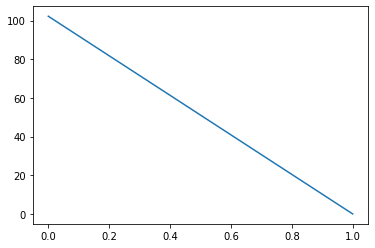

In [5]:
if __name__ == "__main__":
    parity()